# Ensemble Methods #

In [1]:
# Always run this cell
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier,BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
# USE THE FOLLOWING RANDOM STATE FOR YOUR CODE
RANDOM_STATE = 42

## Download the Dataset ##
Download the dataset using the following cell or from this [link](https://github.com/sakrifor/public/tree/master/machine_learning_course/EnsembleDataset) and put the files in the same folder as the .ipynb file. 
In this assignment you are going to work with a dataset originated from the [ImageCLEFmed: The Medical Task 2016](https://www.imageclef.org/2016/medical) and the **Compound figure detection** subtask. The goal of this subtask is to identify whether a figure is a compound figure (one image consists of more than one figure) or not. The train dataset consits of 4197 examples/figures and each figure has 4096 features which were extracted using a deep neural network. The *CLASS* column represents the class of each example where 1 is a compoung figure and 0 is not. 


In [3]:
import urllib.request

url_train = 'https://github.com/sakrifor/public/raw/master/machine_learning_course/EnsembleDataset/train_set.csv'
filename_train = 'train_set.csv'
urllib.request.urlretrieve(url_train, filename_train)
url_test = 'https://github.com/sakrifor/public/raw/master/machine_learning_course/EnsembleDataset/test_set_noclass.csv'
filename_test = 'test_set_noclass.csv'
urllib.request.urlretrieve(url_test, filename_test)

('test_set_noclass.csv', <http.client.HTTPMessage at 0x2df54ada520>)

In [3]:
# Run this cell to load the data
train_set = pd.read_csv("train_set.csv").sample(frac=1).reset_index(drop=True)
train_set.head()
X = train_set.drop(columns=['CLASS'])
y = train_set['CLASS'].values

### 1.1 Voting ###
Create a voting classifier which uses three **simple** estimators/classifiers. Test both soft and hard voting and choose the best one.

In [4]:
# BEGIN CODE HERE

cls1 = ('tree1', DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE))  # Classifier #1
cls2 = ('lrg', LogisticRegression())
cls3 = ('knn', KNeighborsClassifier())
soft_vcls = VotingClassifier([cls1, cls2, cls3], voting='soft')
hard_vcls = VotingClassifier([cls1, cls2, cls3], voting='hard')


In [5]:
svlcs_scores = cross_validate(estimator=soft_vcls, X=X, y=y, cv=10, scoring=['f1_weighted', 'balanced_accuracy'], n_jobs=-1,
    verbose=1, error_score='raise')
s_avg_fmeasure = svlcs_scores['test_f1_weighted'].mean()  # The average f-measure
s_avg_accuracy = svlcs_scores['test_balanced_accuracy'].mean()  # The average accuracy

hvlcs_scores = cross_validate(estimator=hard_vcls, X=X, y=y, cv=10, scoring=['f1_weighted', 'balanced_accuracy'], n_jobs=-1,
    verbose=1, error_score='raise')
h_avg_fmeasure = hvlcs_scores['test_f1_weighted'].mean()  # The average f-measure
h_avg_accuracy = hvlcs_scores['test_balanced_accuracy'].mean()  # The average accuracy
#END CODE HERE

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   30.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   18.6s finished


In [6]:
print("Classifier:")
print(soft_vcls)
print("F1 Weighted-Score: {} & Balanced Accuracy: {}".format(round(s_avg_fmeasure, 4), round(s_avg_accuracy, 4)))

Classifier:
VotingClassifier(estimators=[('tree1',
                              DecisionTreeClassifier(max_depth=2,
                                                     random_state=42)),
                             ('lrg', LogisticRegression()),
                             ('knn', KNeighborsClassifier())],
                 n_jobs=2, voting='soft')
F1 Weighted-Score: 0.8435 & Balanced Accuracy: 0.8359


You should achieve above 82% (Soft Voting Classifier)

In [7]:
print("Classifier:")
print(hard_vcls)
print("F1 Weighted-Score: {} & Balanced Accuracy: {}".format(round(h_avg_fmeasure, 4), round(h_avg_accuracy, 4)))

Classifier:
VotingClassifier(estimators=[('tree1',
                              DecisionTreeClassifier(max_depth=2,
                                                     random_state=42)),
                             ('lrg', LogisticRegression()),
                             ('knn', KNeighborsClassifier())],
                 n_jobs=2)
F1 Weighted-Score: 0.823 & Balanced Accuracy: 0.8103


### 1.2 Stacking ###
Create a stacking classifier which uses two more complex estimators. Try different simple classifiers (like the ones mentioned before) for the combination of the initial estimators.


In [8]:
# BEGIN CODE HERE

cls1 = KNeighborsClassifier()
cls3 = RandomForestClassifier(50, random_state=RANDOM_STATE)
cls2 = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=150, early_stopping=True, learning_rate='adaptive')
scls = StackingClassifier(estimators=[('rfc', cls3), ('knn', cls1), ('tree1', cls2)],n_jobs=-1)  # Stacking Classifier
scores = cross_validate(estimator=scls, X=X, y=y, cv=10, scoring=['f1_weighted', 'balanced_accuracy'],n_jobs=-1)
avg_fmeasure = scores['test_f1_weighted'].mean()  # The average f-measure
avg_accuracy = scores['test_balanced_accuracy'].mean()  # The average accuracy
#END CODE HERE

In [9]:
print("Classifier:")
print(scls)
print("F1 Weighted Score: {} & Balanced Accuracy: {}".format(round(avg_fmeasure, 4), round(avg_accuracy, 4)))

Classifier:
StackingClassifier(estimators=[('rfc',
                                RandomForestClassifier(n_estimators=50,
                                                       random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('tree1',
                                MLPClassifier(early_stopping=True,
                                              hidden_layer_sizes=(100, 100),
                                              learning_rate='adaptive',
                                              max_iter=150))],
                   n_jobs=2)
F1 Weighted Score: 0.8582 & Balanced Accuracy: 0.8525


## 2.0 Randomization ##

**2.1** Create three ensembles of decision trees where each one uses a different method for producing homogeneous ensembles. Compare them with a simple decision tree classifier and report the results in the dictionaries (dict) below using as key the given name of your classifier and as value the f1_weighted/balanced_accuracy score.

In [10]:
ens1 = BaggingClassifier(n_estimators=25,random_state=RANDOM_STATE)
ens2 = AdaBoostClassifier(learning_rate=0.8,random_state=RANDOM_STATE)
ens3 = RandomForestClassifier(max_depth=17,random_state=RANDOM_STATE)
tree = DecisionTreeClassifier(max_depth=6,min_samples_split=6,random_state=RANDOM_STATE)
classifiers = [ens1, ens2, ens3, tree]
names = ['Bagging', 'AdaBoost', 'RandomForest', 'SimpleTree']
f_measures = dict()
accuracies = dict()
for name, cls in zip(names, classifiers):
    scores = cross_validate(estimator=cls, X=X, y=y, cv=10, scoring=['f1_weighted', 'balanced_accuracy'],n_jobs=-1)
    f_measures[name] = scores['test_f1_weighted'].mean()
    accuracies[name] = scores['test_balanced_accuracy'].mean()

# Example f_measures = {'Simple Decision': 0.8551, 'Ensemble with random ...': 0.92, ...}

#END CODE HERE

In [11]:
print(ens1)
print(ens2)
print(ens3)
print(tree)
for name, score in f_measures.items():
    print("Classifier:{} -  F1 Weighted:{}".format(name, round(score, 4)))
for name, score in accuracies.items():
    print("Classifier:{} -  BalancedAccuracy:{}".format(name, round(score, 4)))

BaggingClassifier(n_estimators=25, random_state=42)
AdaBoostClassifier(learning_rate=0.8, random_state=42)
RandomForestClassifier(max_depth=17, random_state=42)
DecisionTreeClassifier(max_depth=6, min_samples_split=6, random_state=42)
Classifier:Bagging -  F1 Weighted:0.7971
Classifier:AdaBoost -  F1 Weighted:0.7925
Classifier:RandomForest -  F1 Weighted:0.8034
Classifier:SimpleTree -  F1 Weighted:0.7095
Classifier:Bagging -  BalancedAccuracy:0.7843
Classifier:AdaBoost -  BalancedAccuracy:0.7823
Classifier:RandomForest -  BalancedAccuracy:0.7869
Classifier:SimpleTree -  BalancedAccuracy:0.6967


**2.2** Describe the classifiers and the results.

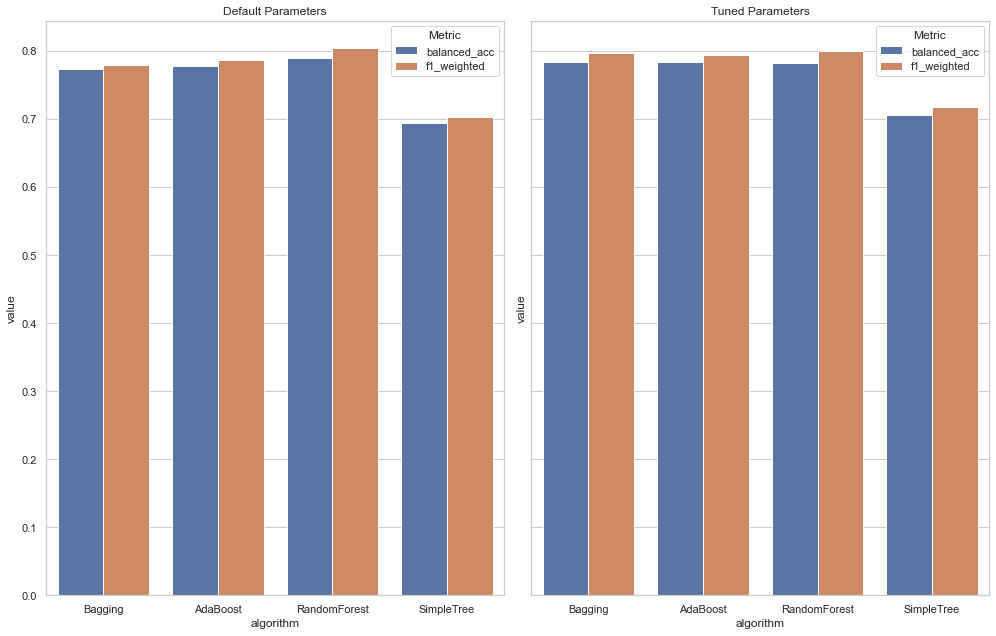

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
#Load saved results for default and tuned classifiers
res_tuned=pd.read_csv('./results_tuned.csv',header=[0])
res_tuned_m=res_tuned.melt(id_vars=['algorithm'],value_vars=['balanced_acc', 'f1_weighted'],var_name='Metric')
res_def=pd.read_csv('./results_default.csv',header=[0])
res_def_m=res_def.melt(id_vars=['algorithm'],value_vars=['balanced_acc', 'f1_weighted'],var_name='Metric')
#Plot the results
fig,axes=plt.subplots(1,2,figsize=(14,9),sharey='all')
sns.set_theme(context='notebook',style='whitegrid')
sns.barplot(ax=axes[0],x='algorithm',y='value',hue='Metric',data=res_def_m)
axes[0].set_title('Default Parameters')
sns.barplot(ax=axes[1],x='algorithm',y='value',hue='Metric',data=res_tuned_m)
axes[1].set_title('Tuned Parameters')
plt.tight_layout()
plt.show()

For the ensemble classifiers I chose a BaggingClassifier, a AdaBoostClassifier and a RandomForestClassifier.
I ran 2 tests. On the first one, I used the default parameters of the classifiers and on the second test, I used GridSearchCV to slightly tune some parameters in a very small search space.
In both tests all 3 ensembles perform better than DecisionTreeClassifier by almost 10%. Between the 3 default ensembles, RandomForest performs the best (probably because it has 100 simple estimators by default, compared to 25 and 10 estimators of AdaBoost and Bagging) but with some tuning they all perform the same.

## 3.0 Creating the best classifier ##

In [30]:
# BEGIN CODE HERE
# The 2 classifiers with the best results yet, parameters found with GridSearchCV for BaggingSVM and trial and error for the BaggingMLP, because each training takes a lot of time
# compared to other methods.

SVM = LinearSVC(max_iter=15,C=2)
MLP = MLPClassifier(hidden_layer_sizes=(100,100),max_iter=100, early_stopping=True, learning_rate='adaptive')
bag_SMV = BaggingClassifier(base_estimator=SVM,n_estimators=100,max_features=0.5,bootstrap_features=True,n_jobs=-1)
bag_MLP = BaggingClassifier(base_estimator=MLP,n_estimators=125,max_features=0.2,bootstrap_features=True,n_jobs=-1)

In [31]:
scores_svm = cross_validate(bag_SMV,X.values,y,cv=10,n_jobs=-1,verbose=2,scoring=['f1_weighted','balanced_accuracy'],error_score='raise')
print(scores_svm['test_f1_weighted'].mean())
print(scores_svm['test_balanced_accuracy'].mean())
print(bag_SMV.get_params())

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.8min finished


0.8560050996572185
0.849851819164169
{'base_estimator__C': 2, 'base_estimator__class_weight': None, 'base_estimator__dual': True, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 15, 'base_estimator__multi_class': 'ovr', 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator': LinearSVC(C=2, max_iter=15), 'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [32]:
scores_mlp = cross_validate(bag_MLP,X.values,y,cv=10,n_jobs=-1,verbose=2,scoring=['f1_weighted','balanced_accuracy'],error_score='raise')
print(scores_mlp['test_f1_weighted'].mean())
print(scores_mlp['test_balanced_accuracy'].mean())
print(bag_MLP.get_params())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 22.2min finished


0.8603200423450875
0.853194251474261
{'base_estimator__activation': 'relu', 'base_estimator__alpha': 0.0001, 'base_estimator__batch_size': 'auto', 'base_estimator__beta_1': 0.9, 'base_estimator__beta_2': 0.999, 'base_estimator__early_stopping': True, 'base_estimator__epsilon': 1e-08, 'base_estimator__hidden_layer_sizes': (100, 100), 'base_estimator__learning_rate': 'adaptive', 'base_estimator__learning_rate_init': 0.001, 'base_estimator__max_fun': 15000, 'base_estimator__max_iter': 100, 'base_estimator__momentum': 0.9, 'base_estimator__n_iter_no_change': 10, 'base_estimator__nesterovs_momentum': True, 'base_estimator__power_t': 0.5, 'base_estimator__random_state': None, 'base_estimator__shuffle': True, 'base_estimator__solver': 'adam', 'base_estimator__tol': 0.0001, 'base_estimator__validation_fraction': 0.1, 'base_estimator__verbose': False, 'base_estimator__warm_start': False, 'base_estimator': MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100),
              learning_r

In [35]:
best_cls = bag_MLP
best_fmeasure = scores_mlp['test_f1_weighted'].mean()
best_accuracy = scores_mlp['test_balanced_accuracy'].mean()
#END CODE HERE

In [36]:
print("Classifier:")
print(best_cls)
print("F1 Weighted-Score:{} & Balanced Accuracy:{}".format(best_fmeasure, best_accuracy))

Classifier:
BaggingClassifier(base_estimator=MLPClassifier(early_stopping=True,
                                               hidden_layer_sizes=(100, 100),
                                               learning_rate='adaptive',
                                               max_iter=100),
                  bootstrap_features=True, max_features=0.2, n_estimators=125)
F1 Weighted-Score:0.8603200423450875 & Balanced Accuracy:0.853194251474261


At first, some methods of section 2 and their variants were tried, such as:
- Random Forest Classifier for different parameters of estimators and tree depth.
- Adaptive Boosting with base estimators, Decision Trees, RBF SVMs and 2-layer MLPs
- Bagging Classifier with Decision Trees.

The ensemble methods with non-linear SVMs as base estimators were really slow to train, caused by the high dimensionality of the features in the dataset and the number of samples. Since the features of the data were mainly uncorrelated, a subset of the features could be used to train linear SMVs (scale better than non-linear) in a Bagging Classifier.
The above method had the best performance yet. So I tuned the parameters with a large grid search and got the above results.(f1: 85.5% ,b_acc: 84.9%)
Finally, the same method was used but with MLPs instead of SVMs. After some tuning of the layers and max iterations of the MLPs, it had around 0.5% increase in both metrics.(f1: 86% ,b_acc: 85.3%)

Stacking SVM Bagging classifiers and/or MLP Bagging classifiers was also tested but had worse results.


Use numpy ndarray instead of Dataframe for the input data, to avoid a UserWarning about feature names.